In [1]:
%load_ext autoreload
%autoreload 2


In [31]:
import keyroom
import jax
import jax.numpy as jnp
import json

# from gymnax.visualize import Visualizer
import visualizer
from xminigrid.rendering.rgb_render import render
import numpy as np
from IPython.display import Image
import minigrid_common

In [3]:
# Open the file and load the JSON data
with open("maze_pairs.json", "r") as file:
    maze_config = json.load(file)[0]

NameError: name 'json' is not defined

In [4]:
from pprint import pprint


pprint(maze_config)

env = keyroom.KeyRoom(
    maze_config=keyroom.shorten_maze_config(maze_config, 1))
env_params = env.default_params()
env_params

{'keys': [['key', 'grey'],
          ['key', 'red'],
          ['key', 'purple'],
          ['key', 'yellow']],
 'pairs': [[['box', 'blue'], ['ball', 'blue']],
           [['box', 'purple'], ['box', 'green']],
           [['ball', 'green'], ['box', 'yellow']],
           [['key', 'blue'], ['key', 'green']]]}


KeyRoomEnvParams(height=19, width=19, view_size=7, render_mode='rgb_array', random_door_loc=False, training=True)

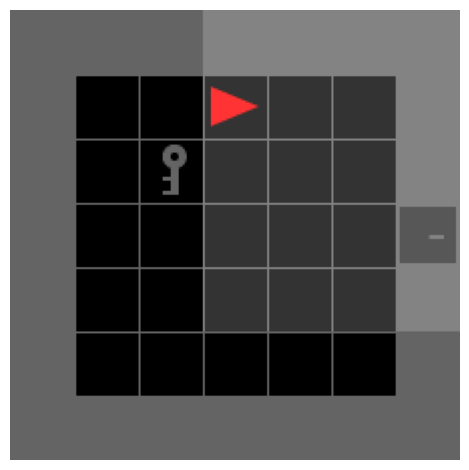

Observation(image=(7, 7, 34), task_w=(4,), state_features=(4,), has_occurred=(4,), pocket=(29,))

In [49]:
rng = jax.random.PRNGKey(2)
rng, rng_ = jax.random.split(rng)
timestep = env.reset(rng_, env_params)

# get image of full state
# state_image = env.render(env_params, timestep)
# visualizer.display_image(state_image)

# get image of what agent observes (theirs is symbolic)
obs_image = keyroom.render_room(timestep.state)
visualizer.display_image(obs_image)

jax.tree_map(lambda x:x.shape, timestep.observation)

In [24]:
rng = jax.random.PRNGKey(6)
rng, rng_ = jax.random.split(rng)
env_params = env_params.replace(training=False)
timestep = env.reset(rng_, env_params)
t_limit = 40

state_seq = [env.render(env_params, timestep)]
obs_seq = [keyroom.render_room(timestep)]
reward_seq = [timestep.reward]

t_counter = 0
while True:
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    action = jax.random.randint(rng_act, (), 0, env.num_actions(env_params))

    timestep = env.step(rng_step, timestep, action, env_params)
    state_seq.append(env.render(env_params, timestep))
    obs_seq.append(keyroom.render_room(timestep))
    reward_seq.append(timestep.reward)

    # obs_image = keyroom.render_room(timestep)
    # visualizer.display_image(obs_image)

    t_counter += 1
    if timestep.last() or t_counter >= t_limit:
        break

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
print(t_counter, sum(reward_seq))

26 1.0


MovieWriter ffmpeg unavailable; using Pillow instead.


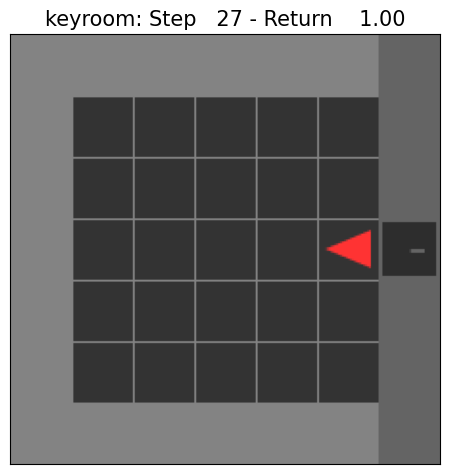

In [28]:
vis = visualizer.Visualizer(env, env_params, obs_seq, cum_rewards)
vis.animate(f"../../analysis_media/anim.gif")
Image(url=f"../../analysis_media/anim.gif")  